# DISCUSSION SPACE ANALYSIS

In [131]:
#!pip install emoji #Run once

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 3.5 MB/s eta 0:00:00


In [145]:
import os
import pandas as pd
from google.colab import drive
from datetime import datetime
import pytz
import re
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

from scipy.interpolate import make_interp_spline

from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import nltk
from nltk.corpus import stopwords
import gensim
from gensim import corpora
from gensim.utils import simple_preprocess
import string

#to be able to deal with emojis
import emoji

from tqdm import tqdm

In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# Mount Google Drive
drive.mount('/content/drive')

# Wait until Google Drive is mounted
while not os.path.exists('/content/drive/My Drive/'):
    pass

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Drive folder to save the file
folder_path = '/content/drive/My Drive/IMT Atlantique/Semester 2/Project Complex/Coding/data/final/'

# Create the folder if it doesn't exist
#os.makedirs(folder_path, exist_ok=True)

### FUNCTIONS

In [6]:
# Function to extract company name and count parts from email address
def extract_company(email):
    match = re.search(r'@([^@]+)\.', email)  # Match text after @ and before .
    if match:
        domain = match.group(1)  # Get the domain
        parts = domain.split('.')
        if len(parts) > 2:
            company = parts[-2]
        elif len(parts) == 2:  # Check if there are more than 1 point
            company = parts[-1]  # Get text before the last point
        elif len(parts) == 1:  # Check if there is at least one point
            company = parts[0]  # Get text after the @ and before the first point
        else:
            company = domain  # If there's only one word after the @ symbol, consider it as the company
        return company.capitalize()  # Capitalize the first letter of the company name and return the count of parts
    return None

In [7]:
# Define the function to replace specific company names with 'Individual Contributor'
def replace_companies(companies):
    for i, company in enumerate(companies):
        if company and company.lower() in ['gmail', 'web', 'outlook', 'mail']:
            companies[i] = 'Individual Contributor'
    return companies

In [80]:
# Directory used to save all images of this notebook
directory = folder_path + 'img_discussion_space_analysis'

try:
    # Check if the directory exists, if not create it
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Directory '{directory}' created successfully!")
    else:
        print(f"Directory '{directory}' already exists.")
except Exception as e:
    print(f"Error creating directory '{directory}': {e}")

Directory '/content/drive/My Drive/IMT Atlantique/Semester 2/Project Complex/Coding/data/final/img_discussion_space_analysis' created successfully!


In [108]:
def plot_chart(dataset, title):
    # Plot Canonical/Ubuntu's contributions over time with only the year on the x-axis
    ax = top_10_contributors_plus_ubuntu_transposed.plot(kind='line', marker='o', figsize=(16, 6))

    # Highlight the Ubuntu line
    ubuntu_line = top_10_contributors_plus_ubuntu_transposed['Ubuntu']
    ubuntu_line.plot(ax=ax, color='red', linestyle='--', marker='o', linewidth=5, label='Ubuntu')

    # Customize the plot
    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel('Number of Contributions')
    plt.grid(False)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    #plt.legend()  # Show legend
    ax.legend(labels=top_10_contributors_plus_ubuntu_transposed, title="Contributors", bbox_to_anchor=(1, 1), loc='upper left')

    # Save the plot as an image file
    filepath = os.path.join(directory, title + '.png')
    plt.savefig(filepath)
    print(f"Plot saved as '{filepath}'")

    plt.show()

### DPKG

In [8]:
dpkg_df = pd.read_csv(folder_path + "email_content_dpkg_company_contributor.csv")

In [9]:
dpkg_df.head(50)

,Date,From,To,Subject,Content,Link,Company
0,2023-12-29 15:49:07+00:00,Niels Thykier <niels@thykier.net>,Dpkg-Maintainers <debian-dpkg@lists.debian.org>,Re: Proper way to do setcap in maintscript,Niels Thykier:,https://lists.debian.org/debian-dpkg/2023/debi...,Thykier
1,2023-12-29 15:49:07+00:00,Niels Thykier <niels@thykier.net>,Dpkg-Maintainers <debian-dpkg@lists.debian.org>,Re: Proper way to do setcap in maintscript,Niels Thykier:,https://lists.debian.org/debian-dpkg/2023/debi...,Thykier
2,2023-12-29 15:49:07+00:00,Niels Thykier <niels@thykier.net>,Dpkg-Maintainers <debian-dpkg@lists.debian.org>,Re: Proper way to do setcap in maintscript,Niels Thykier:,https://lists.debian.org/debian-dpkg/2023/debi...,Thykier
3,2023-12-29 15:49:07+00:00,Niels Thykier <niels@thykier.net>,Dpkg-Maintainers <debian-dpkg@lists.debian.org>,Re: Proper way to do setcap in maintscript,Niels Thykier:,https://lists.debian.org/debian-dpkg/2023/debi...,Thykier
4,2023-12-29 15:49:07+00:00,Niels Thykier <niels@thykier.net>,Dpkg-Maintainers <debian-dpkg@lists.debian.org>,Re: Proper way to do setcap in maintscript,Niels Thykier:,https://lists.debian.org/debian-dpkg/2023/debi...,Thykier
5,2023-12-29 15:49:07+00:00,Niels Thykier <niels@thykier.net>,Dpkg-Maintainers <debian-dpkg@lists.debian.org>,Re: Proper way to do setcap in maintscript,Niels Thykier:,https://lists.debian.org/debian-dpkg/2023/debi...,Thykier
6,2023-12-29 15:49:07+00:00,Niels Thykier <niels@thykier.net>,Dpkg-Maintainers <debian-dpkg@lists.debian.org>,Re: Proper way to do setcap in maintscript,Niels Thykier:,https://lists.debian.org/debian-dpkg/2023/debi...,Thykier
7,2023-12-29 15:49:07+00:00,Niels Thykier <niels@thykier.net>,Dpkg-Maintainers <debian-dpkg@lists.debian.org>,Re: Proper way to do setcap in maintscript,Niels Thykier:,https://lists.debian.org/debian-dpkg/2023/debi...,Thykier
8,2023-12-29 15:49:07+00:00,Niels Thykier <niels@thykier.net>,Dpkg-Maintainers <debian-dpkg@lists.debian.org>,Re: Proper way to do setcap in maintscript,Niels Thykier:,https://lists.debian.org/debian-dpkg/2023/debi...,Thykier
9,2023-12-23 00:20:05+00:00,Debian FTP Masters <ftpmaster@ftp-master.debia...,"Guillem Jover <guillem@debian.org>, Dpkg Devel...",dupload_2.10.5_amd64.changes ACCEPTED into uns...,Thank you for your contribution to Debian.\n\n...,https://lists.debian.org/debian-dpkg/2023/debi...,Debian


#### **Email Thread Analysis**
Identify email threads based on the "Subject" field or by grouping emails with the same "From" and "To" addresses. Analyze the length of threads, the number of participants, response times, so on.

In [10]:
# Convert 'Date' column to datetime
dpkg_df['Date'] = pd.to_datetime(dpkg_df['Date'])

In [11]:
# Group emails by 'Subject' to identify threads
dpkg_email_threads = dpkg_df.groupby('Subject')

In [12]:
# Initialize lists to store analysis results
thread_subjects = []
thread_lengths = []
thread_participants = []
thread_start_dates = []
thread_end_dates = []

In [13]:
# Analyze each thread
for subject, thread_emails in dpkg_email_threads:
    # Get number of emails in the thread
    thread_length = len(thread_emails)

    # Get unique participants in the thread
    participants = thread_emails['From'].unique().tolist()

    # Get start and end dates of the thread
    start_date = thread_emails['Date'].min().strftime("%Y-%m-%d")
    end_date = thread_emails['Date'].max().strftime("%Y-%m-%d")

    # Append results to lists
    thread_subjects.append(subject)
    thread_lengths.append(thread_length)
    thread_participants.append(participants)
    thread_start_dates.append(start_date)
    thread_end_dates.append(end_date)

In [14]:
# Create DataFrame to store analysis results
dpkg_thread_analysis_df = pd.DataFrame({
    'Subject': thread_subjects,
    'Length': thread_lengths,
    'Participants': thread_participants,
    'Start Date': thread_start_dates,
    'End Date': thread_end_dates
})

In [15]:
# Display the thread analysis DataFrame
dpkg_thread_analysis_df = dpkg_thread_analysis_df.sort_values(by='Length', ascending=False, ignore_index=True)

In [16]:
dpkg_thread_analysis_df.head(5)

,Subject,Length,Participants,Start Date,End Date
0,Re: Triggers status?,1022,"[Raphael Hertzog <hertzog@debian.org>, Guillem...",2007-10-07,2007-10-31
1,"Re: git bikeshedding (Re: triggers in dpkg, an...",877,"[Ian Jackson <ian@davenant.greenend.org.uk>, M...",2008-02-24,2008-03-07
2,Re: binary NMUs and version numbers,737,[Goswin von Brederlow <brederlo@informatik.uni...,2004-11-25,2004-12-15
3,Re: DEP 17: Improve support for directory alia...,680,"[Guillem Jover <guillem@debian.org>, Simon Ric...",2023-04-08,2023-07-10
4,Re: Using GNU's install-info in Debian instead...,658,"[Ian Zimmerman <nobrowser@gmail.com>, Ian Jack...",2006-05-19,2006-05-31


In [17]:
dpkg_thread_analysis_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5312 entries, 0 to 5311
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Subject       5312 non-null   object
 1   Length        5312 non-null   int64 
 2   Participants  5312 non-null   object
 3   Start Date    5312 non-null   object
 4   End Date      5312 non-null   object
dtypes: int64(1), object(4)
memory usage: 207.6+ KB


In [18]:
dpkg_thread_analysis_df['Participants']

0       [Raphael Hertzog <hertzog@debian.org>, Guillem...
1       [Ian Jackson <ian@davenant.greenend.org.uk>, M...
2       [Goswin von Brederlow <brederlo@informatik.uni...
3       [Guillem Jover <guillem@debian.org>, Simon Ric...
4       [Ian Zimmerman <nobrowser@gmail.com>, Ian Jack...
                              ...                        
5307           [Jenkins Team at Grml  <jenkins@grml.org>]
5308    [Debian FTP Masters <ftpmaster@ftp-master.debi...
5309              [Ubuntu Merge-o-Matic <mom@ubuntu.com>]
5310             [Christian PERRIER <bubulle@debian.org>]
5311    [Debian FTP Masters <ftpmaster@ftp-master.debi...
Name: Participants, Length: 5312, dtype: object

In [19]:
# Apply the function to extract company names from each email address in the 'Participants' column
dpkg_thread_analysis_df['Participants'] = dpkg_thread_analysis_df['Participants'].apply(lambda emails: [extract_company(email) for email in emails])

In [20]:
# Apply the function to each list element in the 'Participants' column
dpkg_thread_analysis_df['Participants'] = dpkg_thread_analysis_df['Participants'].apply(lambda companies: replace_companies(companies))

In [21]:
# Make the elements unique in each list
dpkg_thread_analysis_df['Participants'] = dpkg_thread_analysis_df['Participants'].apply(lambda emails: list(set(emails)))

In [22]:
dpkg_thread_analysis_df.head(10)

,Subject,Length,Participants,Start Date,End Date
0,Re: Triggers status?,1022,"[Rr, Org, Com, Debian, Greenend, Ieee, Pp, Hum...",2007-10-07,2007-10-31
1,"Re: git bikeshedding (Re: triggers in dpkg, an...",877,"[Org, Yosemite, Greenend, Debian, Dooz, Mit, E...",2008-02-24,2008-03-07
2,Re: binary NMUs and version numbers,737,"[So, Debian, Grep, Uni-tuebingen, Netsplit, Hu...",2004-11-25,2004-12-15
3,Re: DEP 17: Improve support for directory alia...,680,"[Spwhitton, Subdivi, Individual Contributor, D...",2023-04-08,2023-07-10
4,Re: Using GNU's install-info in Debian instead...,658,"[Individual Contributor, Greenend, Debian, Log...",2006-05-19,2006-05-31
5,Re: Transition from dpkg to GNU install-info,641,"[Edpnet, Debian, Logic, Gmx, Centraliens]",2009-03-11,2009-06-29
6,"Re: dpkg semi-hijack - an announcement (also, ...",599,"[Moregruel, Rki, Err, Greenend, Iki, Enst-bret...",2008-03-09,2008-03-14
7,Re: [PATCH] proposed v3 source format using .g...,558,"[Rr, Org, Com, Debian, Greenend, Ieee, Uni-tue...",2007-10-06,2008-02-11
8,Re: Declarative Diversions - GSoC Project Upda...,528,"[Debian, Err, Individual Contributor]",2011-05-30,2011-06-01
9,Re: comments/string changes and issues with dp...,412,"[Loria, Individual Contributor, Greenend, Debi...",2005-07-26,2005-08-31


*Top 10 Discussions with participation of Canonical/Ubuntu*

In [23]:
# Filter the DataFrame to include only rows where 'Ubuntu' is in the list of participants
ubuntu_rows = dpkg_thread_analysis_df[dpkg_thread_analysis_df['Participants'].apply(lambda x: 'Ubuntu' in x)]

# Display the top 10 rows
top_10_ubuntu_rows = ubuntu_rows.head(10)

In [24]:
top_10_ubuntu_rows

,Subject,Length,Participants,Start Date,End Date
0,Re: Triggers status?,1022,"[Rr, Org, Com, Debian, Greenend, Ieee, Pp, Hum...",2007-10-07,2007-10-31
16,"Re: Draft spec for new dpkg ""triggers"" feature...",330,"[So, Eu, Greenend, Debian, Fastmail, Ubuntu, F...",2007-04-11,2007-04-30
37,Re: [PATCH] Dpkg/Shlibs.pm: multiarch search p...,192,"[Individual Contributor, Debian, Wookware, Ubu...",2011-03-21,2011-03-24
40,Re: dotdee: a proposal for improving conffile ...,182,"[Debian, Seanius, Ubuntu, Individual Contributor]",2011-04-29,2011-05-23
112,Re: dpkg: error: duplicate file trigger intere...,103,"[Debian, Ubuntu, Individual Contributor]",2012-06-23,2012-06-24
141,Re: Bug#487437: Please include /etc/dpkg/origi...,89,"[Debian, Unex, Ubuntu]",2009-02-05,2009-04-24
317,Re: Breaks is going to be implemented,48,"[Centraliens, So, Ubuntu]",2006-06-26,2006-07-10
335,Re: dpkg.org wiki data,45,"[Debian, Ubuntu, Wolffelaar]",2006-06-05,2006-06-19
371,dotdee: a proposal for improving conffile mana...,42,[Ubuntu],2011-04-29,2011-04-29
439,Re: Bug#163666: debian-policy: Unclear result ...,38,"[Debian, Ubuntu]",2008-07-06,2009-01-26


In [25]:
# Filter the DataFrame to include only rows where 'Ubuntu' is in the list of participants
ubuntu_rows = dpkg_thread_analysis_df[dpkg_thread_analysis_df['Participants'].apply(lambda x: 'Ubuntu' in x)]

In [26]:
# Find the start date and end date of Ubuntu's collaboration
start_date = ubuntu_rows['Start Date'].min()
end_date = ubuntu_rows['End Date'].max()

In [27]:
print(f"Canonical/Ubuntu's collaboration start date: {start_date}")
print(f"Canonical/Ubuntu's collaboration end date: {end_date}")

Canonical/Ubuntu's collaboration start date: 2006-05-05
Canonical/Ubuntu's collaboration end date: 2018-01-10


In [28]:
# Convert 'Start Date' to datetime format
ubuntu_rows.loc[:, 'Start Date'] = pd.to_datetime(ubuntu_rows['Start Date'])

# Get the Canonical contributions over time
ubuntu_contributions_over_time = ubuntu_rows.groupby(ubuntu_rows['Start Date'].dt.year).size()

<ipython-input-28-b4e7eeae5c08>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ubuntu_rows.loc[:, 'Start Date'] = pd.to_datetime(ubuntu_rows['Start Date'])
<ipython-input-28-b4e7eeae5c08>:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  ubuntu_rows.loc[:, 'Start Date'] = pd.to_datetime(ubuntu_rows['Start Date'])


In [40]:
# Convert Series to DataFrame with a single column
ubuntu_contributions_over_time_df = ubuntu_contributions_over_time.to_frame()

# Transpose the DataFrame
ubuntu_contributions_over_time_transposed = ubuntu_contributions_over_time_df.T

# Replace the index '0' with 'Ubuntu'
ubuntu_contributions_over_time_transposed = ubuntu_contributions_over_time_transposed.rename(index={0: 'Ubuntu'})

# Rename the column 'Start Date' to 'Year'
#ubuntu_contributions_over_time_transposed = ubuntu_contributions_over_time_transposed.rename_axis(columns='Year')
ubuntu_contributions_over_time_transposed = ubuntu_contributions_over_time_transposed

# Print the transposed DataFrame
ubuntu_contributions_over_time_transposed

Start Date,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
Ubuntu,15,24,9,7,6,20,8,2,5,5,2,5


In [38]:
# Convert start_date and end_date to datetime objects
start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

# Filter the DataFrame to include only non-Ubuntu rows within the start and end dates of Ubuntu's collaboration
non_ubuntu_rows_filtered = dpkg_thread_analysis_df[
    (dpkg_thread_analysis_df['Participants'].apply(lambda x: 'Ubuntu' not in x)) &
    (pd.to_datetime(dpkg_thread_analysis_df['Start Date']) >= start_date) &
    (pd.to_datetime(dpkg_thread_analysis_df['End Date']) <= end_date)
]

# Explode the 'Participants' column
non_ubuntu_rows_exploded = non_ubuntu_rows_filtered.explode('Participants')

# Convert 'Start Date' to datetime format
non_ubuntu_rows_exploded['Start Date'] = pd.to_datetime(non_ubuntu_rows_exploded['Start Date'])

# Group by participant and year to get contributions over time for each non-Ubuntu participant
non_ubuntu_contributions_over_time = non_ubuntu_rows_exploded.groupby(['Participants', non_ubuntu_rows_exploded['Start Date'].dt.year]).size().unstack(fill_value=0)

# Transpose the DataFrame to have participants as rows and years as columns
# non_ubuntu_contributions_over_time_transposed = non_ubuntu_contributions_over_time.transpose()

# Display the transposed DataFrame
# non_ubuntu_contributions_over_time_transposed
non_ubuntu_contributions_over_time

Start Date,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
Participants,,,,,,,,,,,,
3dfreestats,1,0,0,0,0,0,0,0,0,0,0,0
Abeckmann,0,0,0,0,0,1,0,0,0,0,0,0
Acryline,0,0,0,0,0,0,1,0,0,0,0,0
Afaics,0,0,0,0,1,0,0,0,0,0,0,0
Aig,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
Xs4all,4,0,0,0,0,0,0,0,0,0,0,0
Yahoo,1,4,0,0,0,0,0,0,0,0,0,0
Yosemite,0,0,5,0,0,0,0,0,0,0,0,0


In [39]:
# Sum the contributions across all years for each participant
non_ubuntu_contributions_over_time['Total Contributions'] = non_ubuntu_contributions_over_time.sum(axis=1)

# Sort the participants based on the total contributions in descending order
top_10_non_ubuntu_participants = non_ubuntu_contributions_over_time.sort_values(by='Total Contributions', ascending=False).head(10)

# Drop the Total Contributions column
top_10_non_ubuntu_participants = top_10_non_ubuntu_participants.drop(columns=['Total Contributions'])

# Display the top 10 participants
top_10_non_ubuntu_participants

Start Date,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
Participants,,,,,,,,,,,,
Debian,114,141,203,209,79,203,98,113,190,104,143,94
Individual Contributor,12,10,18,112,59,81,18,18,18,7,11,9
Grml,0,0,0,0,0,21,4,0,13,42,23,28
Greenend,16,31,19,1,2,5,1,1,0,4,19,12
Thykier,0,0,0,0,0,3,7,3,10,24,6,3
Gmx,1,2,8,8,3,5,3,2,2,2,12,6
Helgefjell,0,1,2,8,1,8,3,3,8,2,8,0
Org,1,2,4,1,3,2,1,2,5,2,2,1
Layer-acht,0,0,0,0,4,0,0,0,5,5,4,2


In [49]:
# Concatenate the two DataFrames with 'ubuntu_contributions_over_time_transposed' as the first row
top_10_contributors_plus_ubuntu = pd.concat([ubuntu_contributions_over_time_transposed] + [top_10_non_ubuntu_participants])

# Rename the 'Start Date' column to 'Year' in top_10_non_ubuntu_participants DataFrame
top_10_contributors_plus_ubuntu = top_10_contributors_plus_ubuntu.rename_axis(columns='Year')

# Print the final DataFrame
top_10_contributors_plus_ubuntu

Year,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
Ubuntu,15,24,9,7,6,20,8,2,5,5,2,5
Debian,114,141,203,209,79,203,98,113,190,104,143,94
Individual Contributor,12,10,18,112,59,81,18,18,18,7,11,9
Grml,0,0,0,0,0,21,4,0,13,42,23,28
Greenend,16,31,19,1,2,5,1,1,0,4,19,12
Thykier,0,0,0,0,0,3,7,3,10,24,6,3
Gmx,1,2,8,8,3,5,3,2,2,2,12,6
Helgefjell,0,1,2,8,1,8,3,3,8,2,8,0
Org,1,2,4,1,3,2,1,2,5,2,2,1
Layer-acht,0,0,0,0,4,0,0,0,5,5,4,2


In [52]:
top_10_contributors_plus_ubuntu_transposed = top_10_contributors_plus_ubuntu.transpose()

,Ubuntu,Debian,Individual Contributor,Grml,Greenend,Thykier,Gmx,Helgefjell,Org,Layer-acht,Kalnischkies
Year,,,,,,,,,,,
2006,15,114,12,0,16,0,1,0,1,0,0
2007,24,141,10,0,31,0,2,1,2,0,0
2008,9,203,18,0,19,0,8,2,4,0,0
2009,7,209,112,0,1,0,8,8,1,0,0
2010,6,79,59,0,2,0,3,1,3,4,0
2011,20,203,81,21,5,3,5,8,2,0,0
2012,8,98,18,4,1,7,3,3,1,0,0
2013,2,113,18,0,1,3,2,3,2,0,0
2014,5,190,18,13,0,10,2,8,5,5,3


Plot saved as '/content/drive/My Drive/IMT Atlantique/Semester 2/Project Complex/Coding/data/final/img_discussion_space_analysis/Canonical Contributions Over Time to DPKG Package.png'


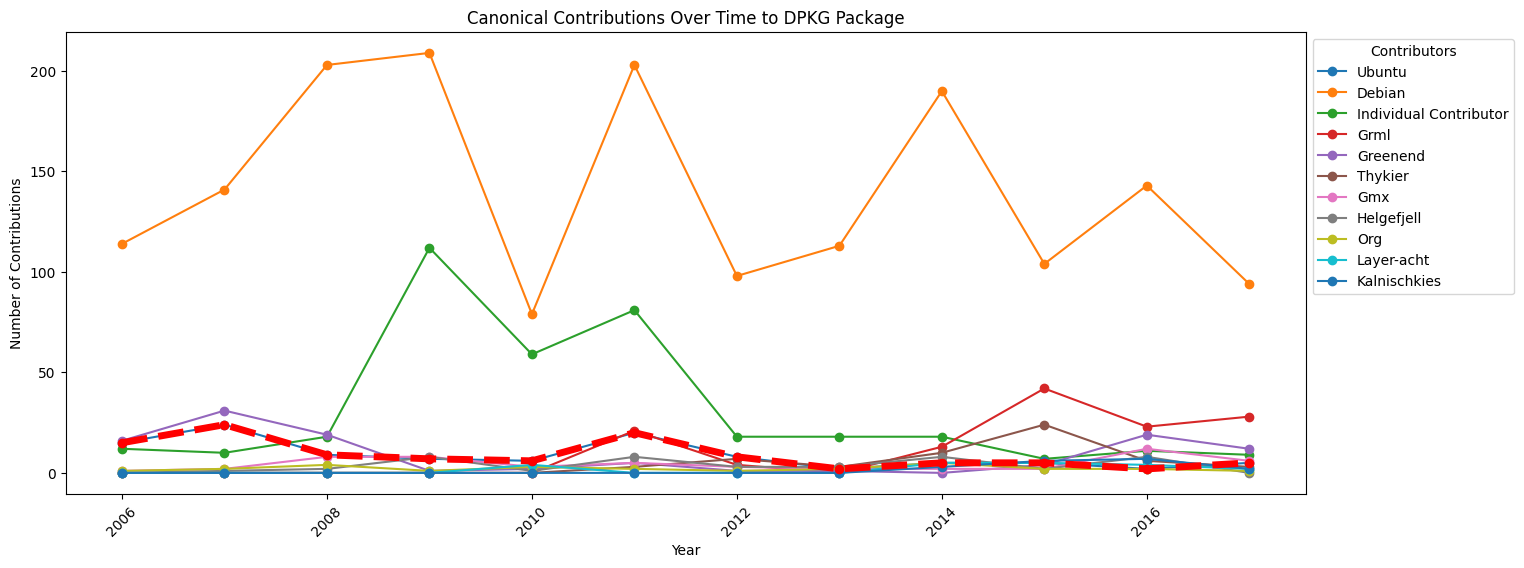

In [109]:
plot_chart(top_10_contributors_plus_ubuntu_transposed, "Canonical Contributions Over Time to DPKG Package")

### GLIBC

In [167]:
glibc_df = pd.read_csv(folder_path + "email_content_glibc_company_contributor.csv")

In [168]:
glibc_df.head(50)

,Date,From,To,Subject,Content,Link,Company
0,2023-12-30 11:36:57+00:00,Debian FTP Masters <ftpmaster@ftp-master.debia...,"Aurelien Jarno <aurel32@debian.org>, GNU Libc ...",glibc_2.38-5_source.changes ACCEPTED into expe...,Thank you for your contribution to Debian.\n\n...,https://lists.debian.org/debian-glibc/2023/deb...,Debian
1,2023-12-30 11:36:57+00:00,Debian FTP Masters <ftpmaster@ftp-master.debia...,"Aurelien Jarno <aurel32@debian.org>, GNU Libc ...",glibc_2.38-5_source.changes ACCEPTED into expe...,Thank you for your contribution to Debian.\n\n...,https://lists.debian.org/debian-glibc/2023/deb...,Debian
2,2023-12-30 11:36:57+00:00,Debian FTP Masters <ftpmaster@ftp-master.debia...,"Aurelien Jarno <aurel32@debian.org>, GNU Libc ...",glibc_2.38-5_source.changes ACCEPTED into expe...,Thank you for your contribution to Debian.\n\n...,https://lists.debian.org/debian-glibc/2023/deb...,Debian
3,2023-12-30 11:36:57+00:00,Debian FTP Masters <ftpmaster@ftp-master.debia...,"Aurelien Jarno <aurel32@debian.org>, GNU Libc ...",glibc_2.38-5_source.changes ACCEPTED into expe...,Thank you for your contribution to Debian.\n\n...,https://lists.debian.org/debian-glibc/2023/deb...,Debian
4,2023-12-30 11:36:57+00:00,Debian FTP Masters <ftpmaster@ftp-master.debia...,"Aurelien Jarno <aurel32@debian.org>, GNU Libc ...",glibc_2.38-5_source.changes ACCEPTED into expe...,Thank you for your contribution to Debian.\n\n...,https://lists.debian.org/debian-glibc/2023/deb...,Debian
5,2023-12-30 11:36:57+00:00,Debian FTP Masters <ftpmaster@ftp-master.debia...,"Aurelien Jarno <aurel32@debian.org>, GNU Libc ...",glibc_2.38-5_source.changes ACCEPTED into expe...,Thank you for your contribution to Debian.\n\n...,https://lists.debian.org/debian-glibc/2023/deb...,Debian
6,2023-12-30 11:36:57+00:00,Debian FTP Masters <ftpmaster@ftp-master.debia...,"Aurelien Jarno <aurel32@debian.org>, GNU Libc ...",glibc_2.38-5_source.changes ACCEPTED into expe...,Thank you for your contribution to Debian.\n\n...,https://lists.debian.org/debian-glibc/2023/deb...,Debian
7,2023-12-30 11:36:57+00:00,Debian FTP Masters <ftpmaster@ftp-master.debia...,"Aurelien Jarno <aurel32@debian.org>, GNU Libc ...",glibc_2.38-5_source.changes ACCEPTED into expe...,Thank you for your contribution to Debian.\n\n...,https://lists.debian.org/debian-glibc/2023/deb...,Debian
8,2023-12-30 11:36:57+00:00,Debian FTP Masters <ftpmaster@ftp-master.debia...,"Aurelien Jarno <aurel32@debian.org>, GNU Libc ...",glibc_2.38-5_source.changes ACCEPTED into expe...,Thank you for your contribution to Debian.\n\n...,https://lists.debian.org/debian-glibc/2023/deb...,Debian
9,2023-12-30 11:36:57+00:00,Debian FTP Masters <ftpmaster@ftp-master.debia...,"Aurelien Jarno <aurel32@debian.org>, GNU Libc ...",glibc_2.38-5_source.changes ACCEPTED into expe...,Thank you for your contribution to Debian.\n\n...,https://lists.debian.org/debian-glibc/2023/deb...,Debian


#### **Email Thread Analysis**
Identify email threads based on the "Subject" field or by grouping emails with the same "From" and "To" addresses. Analyze the length of threads, the number of participants, response times, so on.

In [169]:
# Convert 'Date' column to datetime
glibc_df['Date'] = pd.to_datetime(glibc_df['Date'])

In [170]:
# Group emails by 'Subject' to identify threads
glibc_email_threads = glibc_df.groupby('Subject')

In [171]:
# Initialize lists to store analysis results
thread_subjects = []
thread_lengths = []
thread_participants = []
thread_start_dates = []
thread_end_dates = []

In [172]:
# Analyze each thread
for subject, thread_emails in glibc_email_threads:
    # Get number of emails in the thread
    thread_length = len(thread_emails)

    # Get unique participants in the thread
    participants = thread_emails['From'].unique().tolist()

    # Get start and end dates of the thread
    start_date = thread_emails['Date'].min().strftime("%Y-%m-%d")
    end_date = thread_emails['Date'].max().strftime("%Y-%m-%d")

    # Append results to lists
    thread_subjects.append(subject)
    thread_lengths.append(thread_length)
    thread_participants.append(participants)
    thread_start_dates.append(start_date)
    thread_end_dates.append(end_date)

In [173]:
# Create DataFrame to store analysis results
glibc_thread_analysis_df = pd.DataFrame({
    'Subject': thread_subjects,
    'Length': thread_lengths,
    'Participants': thread_participants,
    'Start Date': thread_start_dates,
    'End Date': thread_end_dates
})

In [174]:
# Display the thread analysis DataFrame
glibc_thread_analysis_df = glibc_thread_analysis_df.sort_values(by='Length', ascending=False, ignore_index=True)

In [175]:
glibc_thread_analysis_df.head(5)

,Subject,Length,Participants,Start Date,End Date
0,cvs commit to glibc-package/debian by dan,1136,[Debian GLibc CVS Master <bcollins@debian.org>],2003-09-12,2004-02-09
1,cvs commit to glibc-package/debian by jbailey,748,[Debian GLibc CVS Master <bcollins@debian.org>],2003-09-22,2004-01-30
2,cvs commit to glibc-package/debian by gotom,599,[Debian GLibc CVS Master <bcollins@debian.org>],2003-08-26,2004-02-06
3,Processed: your mail,558,"[""Debian Bug Tracking System"" <owner@bugs.debi...",2003-08-22,2023-09-01
4,Bug#888073: glibc: Support amd64 systems witho...,464,"[Samuel Thibault <sthibault@debian.org>, Micha...",2018-01-24,2019-09-16


In [176]:
glibc_thread_analysis_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5962 entries, 0 to 5961
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Subject       5962 non-null   object
 1   Length        5962 non-null   int64 
 2   Participants  5962 non-null   object
 3   Start Date    5962 non-null   object
 4   End Date      5962 non-null   object
dtypes: int64(1), object(4)
memory usage: 233.0+ KB


In [177]:
glibc_thread_analysis_df['Participants']

0         [Debian GLibc CVS Master <bcollins@debian.org>]
1         [Debian GLibc CVS Master <bcollins@debian.org>]
2         [Debian GLibc CVS Master <bcollins@debian.org>]
3       ["Debian Bug Tracking System" <owner@bugs.debi...
4       [Samuel Thibault <sthibault@debian.org>, Micha...
                              ...                        
5957            [Carlos O'Donell <carlos@baldric.uwo.ca>]
5958    ["Samuel Thibault (@sthibault)" <gitlab@salsa....
5959    ["Debian Bug Tracking System" <owner@bugs.debi...
5960    ["Debian Bug Tracking System" <owner@bugs.debi...
5961    [owner@bugs.debian.org(Debian Bug Tracking Sys...
Name: Participants, Length: 5962, dtype: object

In [178]:
# Apply the function to extract company names from each email address in the 'Participants' column
glibc_thread_analysis_df['Participants'] = glibc_thread_analysis_df['Participants'].apply(lambda emails: [extract_company(email) for email in emails])

In [179]:
# Apply the function to each list element in the 'Participants' column
glibc_thread_analysis_df['Participants'] = glibc_thread_analysis_df['Participants'].apply(lambda companies: replace_companies(companies))

In [180]:
# Make the elements unique in each list
glibc_thread_analysis_df['Participants'] = glibc_thread_analysis_df['Participants'].apply(lambda emails: list(set(emails)))

In [181]:
glibc_thread_analysis_df.head(10)

,Subject,Length,Participants,Start Date,End Date
0,cvs commit to glibc-package/debian by dan,1136,[Debian],2003-09-12,2004-02-09
1,cvs commit to glibc-package/debian by jbailey,748,[Debian],2003-09-22,2004-01-30
2,cvs commit to glibc-package/debian by gotom,599,[Debian],2003-08-26,2004-02-06
3,Processed: your mail,558,[Debian],2003-08-22,2023-09-01
4,Bug#888073: glibc: Support amd64 systems witho...,464,"[Suse, Systemhalted, Aurel32, Debian, 0c3, Gmx]",2018-01-24,2019-09-16
5,cvs commit to glibc-package/debian/rules.d by dan,393,[Debian],2003-10-02,2004-02-09
6,Re: Testing/help needed - experimental glibc v...,382,"[Unsw, Brturbo, Debian, Or, Nisa, Ens-lyon]",2003-10-21,2003-10-24
7,cvs commit to glibc-package/debian/sysdeps by dan,349,[Debian],2003-10-02,2004-01-27
8,cvs commit to glibc-package/debian by pb,348,[Debian],2003-08-21,2003-11-09
9,[Git][glibc-team/glibc][sid] debian/patches/gi...,328,[Debian],2018-03-08,2023-09-14


In [186]:
# Filter the DataFrame to include only rows where 'Ubuntu' is in the list of participants
ubuntu_rows = glibc_thread_analysis_df[glibc_thread_analysis_df['Participants'].apply(lambda x: 'Ubuntu' in x)]

# Display the top 10 rows
top_10_ubuntu_rows = ubuntu_rows.head(10)

In [187]:
top_10_ubuntu_rows

,Subject,Length,Participants,Start Date,End Date
578,Bug#954112: tzdata: Add ICU tzdata files,26,"[Aurel32, Canonical, Ubuntu]",2020-10-19,2021-01-04
4412,Bug#874491: [patch] fix glibc-2.25 /26 stage1 ...,5,[Ubuntu],2017-09-06,2017-09-06


In [188]:
# Filter the DataFrame to include only rows where 'Ubuntu' is in the list of participants
ubuntu_rows = glibc_thread_analysis_df[glibc_thread_analysis_df['Participants'].apply(lambda x: 'Ubuntu' in x)]

In [189]:
# Find the start date and end date of Ubuntu's collaboration
start_date = ubuntu_rows['Start Date'].min()
end_date = ubuntu_rows['End Date'].max()

In [190]:
print(f"Canonical/Ubuntu's collaboration start date: {start_date}")
print(f"Canonical/Ubuntu's collaboration end date: {end_date}")

Canonical/Ubuntu's collaboration start date: 2017-09-06
Canonical/Ubuntu's collaboration end date: 2021-01-04


In [191]:
# Convert 'Start Date' to datetime format
ubuntu_rows.loc[:, 'Start Date'] = pd.to_datetime(ubuntu_rows['Start Date'])

# Get the Canonical contributions over time
ubuntu_contributions_over_time = ubuntu_rows.groupby(ubuntu_rows['Start Date'].dt.year).size()

<ipython-input-191-b4e7eeae5c08>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ubuntu_rows.loc[:, 'Start Date'] = pd.to_datetime(ubuntu_rows['Start Date'])
<ipython-input-191-b4e7eeae5c08>:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  ubuntu_rows.loc[:, 'Start Date'] = pd.to_datetime(ubuntu_rows['Start Date'])


In [192]:
# Convert Series to DataFrame with a single column
ubuntu_contributions_over_time_df = ubuntu_contributions_over_time.to_frame()

# Transpose the DataFrame
ubuntu_contributions_over_time_transposed = ubuntu_contributions_over_time_df.T

# Replace the index '0' with 'Ubuntu'
ubuntu_contributions_over_time_transposed = ubuntu_contributions_over_time_transposed.rename(index={0: 'Ubuntu'})

# Rename the column 'Start Date' to 'Year'
#ubuntu_contributions_over_time_transposed = ubuntu_contributions_over_time_transposed.rename_axis(columns='Year')
ubuntu_contributions_over_time_transposed = ubuntu_contributions_over_time_transposed

# Print the transposed DataFrame
ubuntu_contributions_over_time_transposed

Start Date,2017,2020
Ubuntu,1,1


In [193]:
# Convert start_date and end_date to datetime objects
start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

# Filter the DataFrame to include only non-Ubuntu rows within the start and end dates of Ubuntu's collaboration
non_ubuntu_rows_filtered = glibc_thread_analysis_df[
    (glibc_thread_analysis_df['Participants'].apply(lambda x: 'Ubuntu' not in x)) &
    (pd.to_datetime(glibc_thread_analysis_df['Start Date']) >= start_date) &
    (pd.to_datetime(glibc_thread_analysis_df['End Date']) <= end_date)
]

# Explode the 'Participants' column
non_ubuntu_rows_exploded = non_ubuntu_rows_filtered.explode('Participants')

# Convert 'Start Date' to datetime format
non_ubuntu_rows_exploded['Start Date'] = pd.to_datetime(non_ubuntu_rows_exploded['Start Date'])

# Group by participant and year to get contributions over time for each non-Ubuntu participant
non_ubuntu_contributions_over_time = non_ubuntu_rows_exploded.groupby(['Participants', non_ubuntu_rows_exploded['Start Date'].dt.year]).size().unstack(fill_value=0)

# Transpose the DataFrame to have participants as rows and years as columns
# non_ubuntu_contributions_over_time_transposed = non_ubuntu_contributions_over_time.transpose()

# Display the transposed DataFrame
# non_ubuntu_contributions_over_time_transposed
non_ubuntu_contributions_over_time

Start Date,2017,2018,2019,2020,2021
Participants,,,,,
0c3,0,2,0,0,0
Abromeit,0,0,0,1,0
Adgroupmedia,0,0,4,0,0
Adslead,0,0,1,0,0
Afaics,0,0,0,2,0
...,...,...,...,...,...
Yahoo,0,0,4,0,0
Ydalnhfd,0,0,1,0,0
Yucom,0,0,1,1,0


In [194]:
# Sum the contributions across all years for each participant
non_ubuntu_contributions_over_time['Total Contributions'] = non_ubuntu_contributions_over_time.sum(axis=1)

# Sort the participants based on the total contributions in descending order
top_10_non_ubuntu_participants = non_ubuntu_contributions_over_time.sort_values(by='Total Contributions', ascending=False).head(10)

# Drop the Total Contributions column
top_10_non_ubuntu_participants = top_10_non_ubuntu_participants.drop(columns=['Total Contributions'])

# Display the top 10 participants
top_10_non_ubuntu_participants

Start Date,2017,2018,2019,2020,2021
Participants,,,,,
Debian,613,745,354,455,30
Aurel32,18,44,27,47,1
Individual Contributor,13,25,15,14,2
Enyo,1,11,8,12,0
Org,3,6,5,9,0
Subdivi,2,10,1,6,0
Suse,0,2,0,16,0
Gmx,2,4,5,5,0
Fu-berlin,2,7,2,5,0


In [200]:
# Concatenate the two DataFrames with 'ubuntu_contributions_over_time_transposed' as the first row
top_10_contributors_plus_ubuntu = pd.concat([ubuntu_contributions_over_time_transposed] + [top_10_non_ubuntu_participants])

# Rename the 'Start Date' column to 'Year' in top_10_non_ubuntu_participants DataFrame
top_10_contributors_plus_ubuntu = top_10_contributors_plus_ubuntu.rename_axis(columns='Year')

# Fill NaN values with 0 and convert all values to integers
top_10_contributors_plus_ubuntu = top_10_contributors_plus_ubuntu.fillna(0).astype(int)

# Sort the columns in ascending order
top_10_contributors_plus_ubuntu = top_10_contributors_plus_ubuntu.reindex(sorted(top_10_contributors_plus_ubuntu.columns), axis=1)

# Print the final DataFrame
top_10_contributors_plus_ubuntu

Year,2017,2018,2019,2020,2021
Ubuntu,1,0,0,1,0
Debian,613,745,354,455,30
Aurel32,18,44,27,47,1
Individual Contributor,13,25,15,14,2
Enyo,1,11,8,12,0
Org,3,6,5,9,0
Subdivi,2,10,1,6,0
Suse,0,2,0,16,0
Gmx,2,4,5,5,0
Fu-berlin,2,7,2,5,0


In [201]:
top_10_contributors_plus_ubuntu_transposed = top_10_contributors_plus_ubuntu.transpose()

Plot saved as '/content/drive/My Drive/IMT Atlantique/Semester 2/Project Complex/Coding/data/final/img_discussion_space_analysis/Canonical Contributions Over Time to GLIBC Package.png'


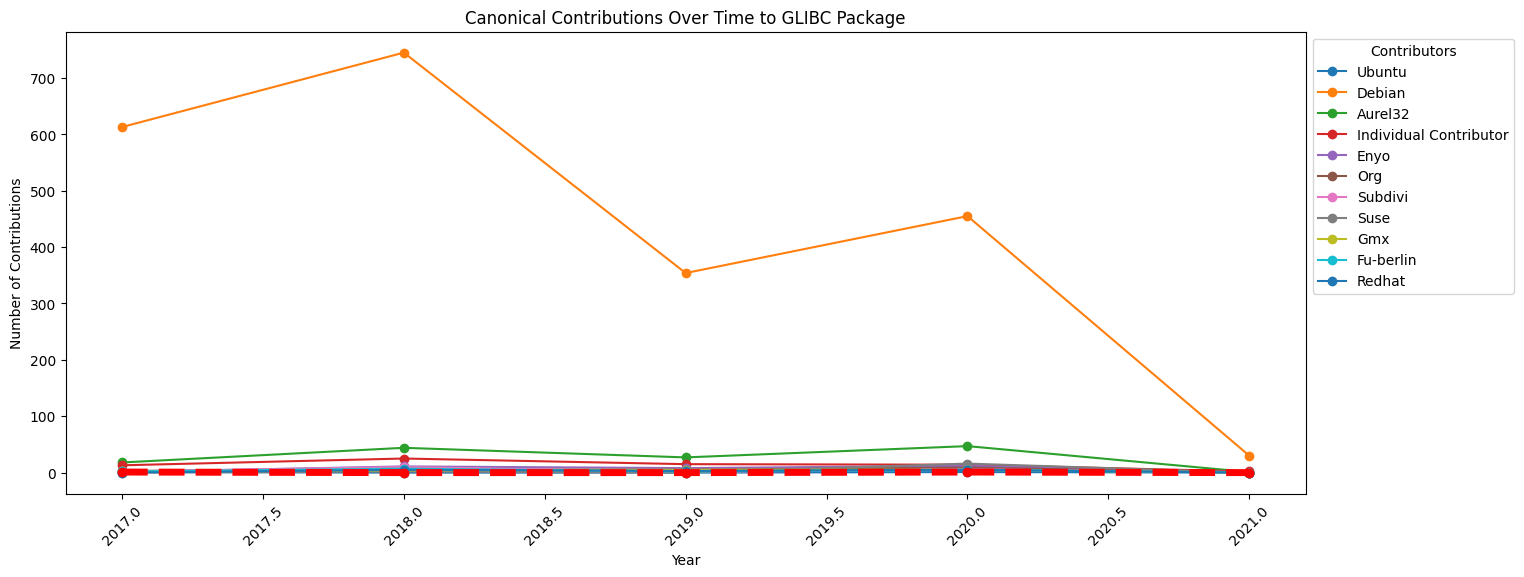

In [202]:
plot_chart(top_10_contributors_plus_ubuntu_transposed, "Canonical Contributions Over Time to GLIBC Package")

### SYSTEMD

In [203]:
systemd_df = pd.read_csv(folder_path + "email_content_systemd_company_contributor.csv")

In [204]:
systemd_df.head(50)

,Date,From,To,Subject,Content,Link,Company
0,2023-12-31 17:57:10+00:00,Debian Bug Tracking System <owner@bugs.debian....,NaN,Processed: archiving 1056135,Processing commands forcontrol at bugs.debian....,https://alioth-lists.debian.net/pipermail/pkg-...,Debian
1,2023-12-31 17:54:04+00:00,Debian Bug Tracking System <owner@bugs.debian....,NaN,Processed: tagging 1058880,Processing commands forcontrol at bugs.debian....,https://alioth-lists.debian.net/pipermail/pkg-...,Debian
2,2023-12-31 17:54:03+00:00,Debian Bug Tracking System <owner@bugs.debian....,NaN,"Processed: unarchiving 1056135, fixed 1056135 ...",Processing commands forcontrol at bugs.debian....,https://alioth-lists.debian.net/pipermail/pkg-...,Debian
3,2023-12-31 17:18:05+00:00,Debian Bug Tracking System <owner@bugs.debian....,NaN,Bug#1053872: marked as done (systemd with high...,"Your message dated Sun, 31 Dec 2023 18:14:47 +...",https://alioth-lists.debian.net/pipermail/pkg-...,Debian
4,2023-12-31 17:06:03+00:00,Debian Bug Tracking System <owner@bugs.debian....,NaN,Bug#1051843: marked as done (systemd: Restart=...,"Your message dated Sun, 31 Dec 2023 18:03:15 +...",https://alioth-lists.debian.net/pipermail/pkg-...,Debian
5,2023-12-31 16:59:04+00:00,Michael Biebl <biebl@debian.org>,NaN,Bug#1058880: systemd-binfmt.service: unit fail...,Am 31.12.23 um 17:43 schrieb Michael Biebl:\n\...,https://alioth-lists.debian.net/pipermail/pkg-...,Debian
6,2023-12-31 16:57:03+00:00,Debian Bug Tracking System <owner@bugs.debian....,NaN,"Processed: found 1052365 in 252.11-1, fixed 10...",Processing commands forcontrol at bugs.debian....,https://alioth-lists.debian.net/pipermail/pkg-...,Debian
7,2023-12-31 16:48:50+00:00,Michael Biebl <biebl@debian.org>,NaN,Bug#1059216: Problem configuring polkitd after...,"Adamo,\n\ncan you send me the output of\n\nls ...",https://alioth-lists.debian.net/pipermail/pkg-...,Debian
8,2023-12-31 16:44:56+00:00,Aurelien Jarno <aurel32@debian.org>,NaN,Bug#1058880: systemd-binfmt.service: unit fail...,"On 2023-12-31 17:43, Michael Biebl wrote:\n>On...",https://alioth-lists.debian.net/pipermail/pkg-...,Debian
9,2023-12-31 16:43:50+00:00,Michael Biebl <biebl@debian.org>,NaN,Bug#1058880: systemd-binfmt.service: unit fail...,"On Mon, 18 Dec 2023 01:47:51 +0100 Michael Bie...",https://alioth-lists.debian.net/pipermail/pkg-...,Debian


#### **Email Thread Analysis**
Identify email threads based on the "Subject" field or by grouping emails with the same "From" and "To" addresses. Analyze the length of threads, the number of participants, response times, so on.

In [205]:
# Convert 'Date' column to datetime
systemd_df['Date'] = pd.to_datetime(systemd_df['Date'])

In [206]:
# Group emails by 'Subject' to identify threads
systemd_email_threads = systemd_df.groupby('Subject')

In [207]:
# Initialize lists to store analysis results
thread_subjects = []
thread_lengths = []
thread_participants = []
thread_start_dates = []
thread_end_dates = []

In [208]:
# Analyze each thread
for subject, thread_emails in systemd_email_threads:
    # Get number of emails in the thread
    thread_length = len(thread_emails)

    # Get unique participants in the thread
    participants = thread_emails['From'].unique().tolist()

    # Get start and end dates of the thread
    start_date = thread_emails['Date'].min().strftime("%Y-%m-%d")
    end_date = thread_emails['Date'].max().strftime("%Y-%m-%d")

    # Append results to lists
    thread_subjects.append(subject)
    thread_lengths.append(thread_length)
    thread_participants.append(participants)
    thread_start_dates.append(start_date)
    thread_end_dates.append(end_date)

In [209]:
# Create DataFrame to store analysis results
systemd_thread_analysis_df = pd.DataFrame({
    'Subject': thread_subjects,
    'Length': thread_lengths,
    'Participants': thread_participants,
    'Start Date': thread_start_dates,
    'End Date': thread_end_dates
})

In [210]:
# Display the thread analysis DataFrame
systemd_thread_analysis_df = systemd_thread_analysis_df.sort_values(by='Length', ascending=False, ignore_index=True)

In [211]:
systemd_thread_analysis_df.head(5)

,Subject,Length,Participants,Start Date,End Date
0,[bts-link] source package systemd,263,[debian-bts-link at lists.debian.org <debian-b...,2014-05-05,2023-12-07
1,Processed: [bts-link] source package systemd,143,[Debian Bug Tracking System <owner@bugs.debian...,2014-05-22,2023-12-07
2,"Bug#832713: systemd: after ""systemd (231-1) un...",47,"[Pete Batard <pete@akeo.ie>, Felipe Sateler <f...",2016-07-28,2016-09-13
3,Bug#908796: udev (with sysvinit) fails to find...,47,"[Trek <trek00@inbox.ru>, Michael Biebl <biebl@...",2018-09-14,2019-03-05
4,Processed: your mail,46,[Debian Bug Tracking System <owner@bugs.debian...,2014-11-09,2023-12-03


In [212]:
systemd_thread_analysis_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11933 entries, 0 to 11932
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Subject       11933 non-null  object
 1   Length        11933 non-null  int64 
 2   Participants  11933 non-null  object
 3   Start Date    11933 non-null  object
 4   End Date      11933 non-null  object
dtypes: int64(1), object(4)
memory usage: 466.3+ KB


In [213]:
systemd_thread_analysis_df['Participants']

0        [debian-bts-link at lists.debian.org <debian-b...
1        [Debian Bug Tracking System <owner@bugs.debian...
2        [Pete Batard <pete@akeo.ie>, Felipe Sateler <f...
3        [Trek <trek00@inbox.ru>, Michael Biebl <biebl@...
4        [Debian Bug Tracking System <owner@bugs.debian...
                               ...                        
11928         [aglaw at nulau.edu.ua <aglaw@nulau.edu.ua>]
11929       [James Martins <investgb90@razintplasint.com>]
11930                  [RALPH ADAMS <ralphaa02@gmail.com>]
11931    [Informática Ocasión <comercial2@informaticaoc...
11932    [Ministerio del Interior <notificacion15@inter...
Name: Participants, Length: 11933, dtype: object

In [214]:
# Apply the function to extract company names from each email address in the 'Participants' column
systemd_thread_analysis_df['Participants'] = systemd_thread_analysis_df['Participants'].apply(lambda emails: [extract_company(email) for email in emails])

In [215]:
# Apply the function to each list element in the 'Participants' column
systemd_thread_analysis_df['Participants'] = systemd_thread_analysis_df['Participants'].apply(lambda companies: replace_companies(companies))

In [216]:
# Make the elements unique in each list
systemd_thread_analysis_df['Participants'] = systemd_thread_analysis_df['Participants'].apply(lambda emails: list(set(emails)))

In [217]:
systemd_thread_analysis_df.head(10)

,Subject,Length,Participants,Start Date,End Date
0,[bts-link] source package systemd,263,"[Debian, Alioth]",2014-05-05,2023-12-07
1,Processed: [bts-link] source package systemd,143,"[Debian, Edu]",2014-05-22,2023-12-07
2,"Bug#832713: systemd: after ""systemd (231-1) un...",47,"[Debian, Akeo, Pobox, Free, Rcthomas]",2016-07-28,2016-09-13
3,Bug#908796: udev (with sysvinit) fails to find...,47,"[Debian, K2di, Fatal, Inbox]",2018-09-14,2019-03-05
4,Processed: your mail,46,[Debian],2014-11-09,2023-12-03
5,"Bug#918764: udev: ""udevadm control --reload-ru...",45,"[Debian, Free, Gedalya, Individual Contributor]",2019-01-09,2019-02-04
6,jessie: help debugging NFS shares not mounted ...,35,[Debian],2016-01-25,2016-03-18
7,"Bug#754218: boot hangs forever on LSB job ""rai...",35,"[Individual Contributor, Debian, Scientia, Mai...",2014-07-08,2014-12-18
8,"Bug#845302: systemd: 232-6:Failed to boot, mak...",33,"[Debian, Individual Contributor]",2016-11-22,2016-11-25
9,No subject,32,"[Lacipres, Individual Contributor, Es, Snet, H...",2014-12-29,2023-10-01


In [218]:
# Filter the DataFrame to include only rows where 'Ubuntu' is in the list of participants
ubuntu_rows = systemd_thread_analysis_df[systemd_thread_analysis_df['Participants'].apply(lambda x: 'Ubuntu' in x)]

# Display the top 10 rows
top_10_ubuntu_rows = ubuntu_rows.head(10)

In [219]:
top_10_ubuntu_rows

,Subject,Length,Participants,Start Date,End Date
19,Bug#771653: systemd 217 breaks X11 (not more k...,22,"[Debian, Free, Ubuntu]",2014-12-01,2014-12-03
143,Bug#771739: could not start nodm with systemd ...,11,"[Debian, Jidanni, Ubuntu]",2014-12-01,2014-12-02
355,Bug#764607: systemd: systemctl does not re-cre...,7,"[Debian, Ubuntu, Com, Individual Contributor]",2014-10-09,2020-02-01
439,Bug#888126: [patch] Please enable systemd-sysu...,7,"[Debian, Ubuntu]",2018-01-23,2018-03-11
476,Bug#756023: init: Please drop Essential:yes fr...,6,"[Debian, Gmx, Ubuntu]",2014-07-25,2014-08-27
1230,Bug#769528: systemd: ifup@ services failing if...,4,"[Debian, Ubuntu]",2014-11-14,2014-11-15
1247,Bug#770633: systemd: Suggestion for a method t...,4,"[Canonical, Ubuntu, Individual Contributor]",2014-11-22,2014-11-25
1316,Bug#768456: Version 3 including ansgar's and p...,3,"[Debian, Ubuntu]",2014-11-07,2014-11-12
1386,Bug#1003580: systemd: broken symlink: /lib/sys...,3,"[Debian, Ubuntu]",2022-01-12,2022-01-12
1406,Bug#860246: [PATCH] udev.postinst: preserve vi...,3,"[Debian, Ubuntu]",2017-04-13,2017-04-13


In [220]:
# Filter the DataFrame to include only rows where 'Ubuntu' is in the list of participants
ubuntu_rows = systemd_thread_analysis_df[systemd_thread_analysis_df['Participants'].apply(lambda x: 'Ubuntu' in x)]

In [221]:
# Find the start date and end date of Ubuntu's collaboration
start_date = ubuntu_rows['Start Date'].min()
end_date = ubuntu_rows['End Date'].max()

In [222]:
print(f"Canonical/Ubuntu's collaboration start date: {start_date}")
print(f"Canonical/Ubuntu's collaboration end date: {end_date}")

Canonical/Ubuntu's collaboration start date: 2013-07-15
Canonical/Ubuntu's collaboration end date: 2022-01-12


In [223]:
# Convert 'Start Date' to datetime format
ubuntu_rows.loc[:, 'Start Date'] = pd.to_datetime(ubuntu_rows['Start Date'])

# Get the Canonical contributions over time
ubuntu_contributions_over_time = ubuntu_rows.groupby(ubuntu_rows['Start Date'].dt.year).size()

<ipython-input-223-b4e7eeae5c08>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ubuntu_rows.loc[:, 'Start Date'] = pd.to_datetime(ubuntu_rows['Start Date'])
<ipython-input-223-b4e7eeae5c08>:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  ubuntu_rows.loc[:, 'Start Date'] = pd.to_datetime(ubuntu_rows['Start Date'])


In [224]:
# Convert Series to DataFrame with a single column
ubuntu_contributions_over_time_df = ubuntu_contributions_over_time.to_frame()

# Transpose the DataFrame
ubuntu_contributions_over_time_transposed = ubuntu_contributions_over_time_df.T

# Replace the index '0' with 'Ubuntu'
ubuntu_contributions_over_time_transposed = ubuntu_contributions_over_time_transposed.rename(index={0: 'Ubuntu'})

# Rename the column 'Start Date' to 'Year'
#ubuntu_contributions_over_time_transposed = ubuntu_contributions_over_time_transposed.rename_axis(columns='Year')
ubuntu_contributions_over_time_transposed = ubuntu_contributions_over_time_transposed

# Print the transposed DataFrame
ubuntu_contributions_over_time_transposed

Start Date,2013,2014,2016,2017,2018,2019,2020,2022
Ubuntu,2,15,1,5,2,1,1,1


In [225]:
# Convert start_date and end_date to datetime objects
start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

# Filter the DataFrame to include only non-Ubuntu rows within the start and end dates of Ubuntu's collaboration
non_ubuntu_rows_filtered = systemd_thread_analysis_df[
    (systemd_thread_analysis_df['Participants'].apply(lambda x: 'Ubuntu' not in x)) &
    (pd.to_datetime(systemd_thread_analysis_df['Start Date']) >= start_date) &
    (pd.to_datetime(systemd_thread_analysis_df['End Date']) <= end_date)
]

# Explode the 'Participants' column
non_ubuntu_rows_exploded = non_ubuntu_rows_filtered.explode('Participants')

# Convert 'Start Date' to datetime format
non_ubuntu_rows_exploded['Start Date'] = pd.to_datetime(non_ubuntu_rows_exploded['Start Date'])

# Group by participant and year to get contributions over time for each non-Ubuntu participant
non_ubuntu_contributions_over_time = non_ubuntu_rows_exploded.groupby(['Participants', non_ubuntu_rows_exploded['Start Date'].dt.year]).size().unstack(fill_value=0)

# Transpose the DataFrame to have participants as rows and years as columns
# non_ubuntu_contributions_over_time_transposed = non_ubuntu_contributions_over_time.transpose()

# Display the transposed DataFrame
# non_ubuntu_contributions_over_time_transposed
non_ubuntu_contributions_over_time

Start Date,2013,2014,2016,2017,2018,2019,2020,2021,2022
Participants,,,,,,,,,
0ppr,0,0,0,0,1,0,0,0,0
139,0,0,0,0,0,0,0,1,0
163,0,0,0,0,1,0,1,1,0
1and1,0,0,0,0,1,0,0,0,0
43-1,0,1,1,2,1,7,0,6,0
...,...,...,...,...,...,...,...,...,...
Zugschlus,0,3,11,10,4,3,3,3,0
Zumstrull,0,0,2,1,0,0,0,0,0
Zurisee,0,0,0,0,0,0,1,0,0


In [226]:
# Sum the contributions across all years for each participant
non_ubuntu_contributions_over_time['Total Contributions'] = non_ubuntu_contributions_over_time.sum(axis=1)

# Sort the participants based on the total contributions in descending order
top_10_non_ubuntu_participants = non_ubuntu_contributions_over_time.sort_values(by='Total Contributions', ascending=False).head(10)

# Drop the Total Contributions column
top_10_non_ubuntu_participants = top_10_non_ubuntu_participants.drop(columns=['Total Contributions'])

# Display the top 10 participants
top_10_non_ubuntu_participants

Start Date,2013,2014,2016,2017,2018,2019,2020,2021,2022
Participants,,,,,,,,,
Debian,426,1667,1431,1155,1089,1046,723,569,38
Individual Contributor,27,220,116,76,93,117,56,40,0
Com,7,15,13,19,6,7,8,2,0
Gmx,4,18,14,9,5,10,3,3,2
Yahoo,2,26,7,14,10,7,1,0,0
Michaelbiebl,7,10,9,8,7,7,8,8,0
Jidanni,0,16,20,4,6,3,8,5,0
Org,6,16,8,5,10,8,4,3,0
Free,3,13,11,16,6,3,2,1,0


In [227]:
# Concatenate the two DataFrames with 'ubuntu_contributions_over_time_transposed' as the first row
top_10_contributors_plus_ubuntu = pd.concat([ubuntu_contributions_over_time_transposed] + [top_10_non_ubuntu_participants])

# Rename the 'Start Date' column to 'Year' in top_10_non_ubuntu_participants DataFrame
top_10_contributors_plus_ubuntu = top_10_contributors_plus_ubuntu.rename_axis(columns='Year')

# Fill NaN values with 0 and convert all values to integers
top_10_contributors_plus_ubuntu = top_10_contributors_plus_ubuntu.fillna(0).astype(int)

# Sort the columns in ascending order
top_10_contributors_plus_ubuntu = top_10_contributors_plus_ubuntu.reindex(sorted(top_10_contributors_plus_ubuntu.columns), axis=1)

# Print the final DataFrame
top_10_contributors_plus_ubuntu

Year,2013,2014,2016,2017,2018,2019,2020,2021,2022
Ubuntu,2,15,1,5,2,1,1,0,1
Debian,426,1667,1431,1155,1089,1046,723,569,38
Individual Contributor,27,220,116,76,93,117,56,40,0
Com,7,15,13,19,6,7,8,2,0
Gmx,4,18,14,9,5,10,3,3,2
Yahoo,2,26,7,14,10,7,1,0,0
Michaelbiebl,7,10,9,8,7,7,8,8,0
Jidanni,0,16,20,4,6,3,8,5,0
Org,6,16,8,5,10,8,4,3,0
Free,3,13,11,16,6,3,2,1,0


In [228]:
top_10_contributors_plus_ubuntu_transposed = top_10_contributors_plus_ubuntu.transpose()

Plot saved as '/content/drive/My Drive/IMT Atlantique/Semester 2/Project Complex/Coding/data/final/img_discussion_space_analysis/Canonical Contributions Over Time to SYSTEMD Package.png'


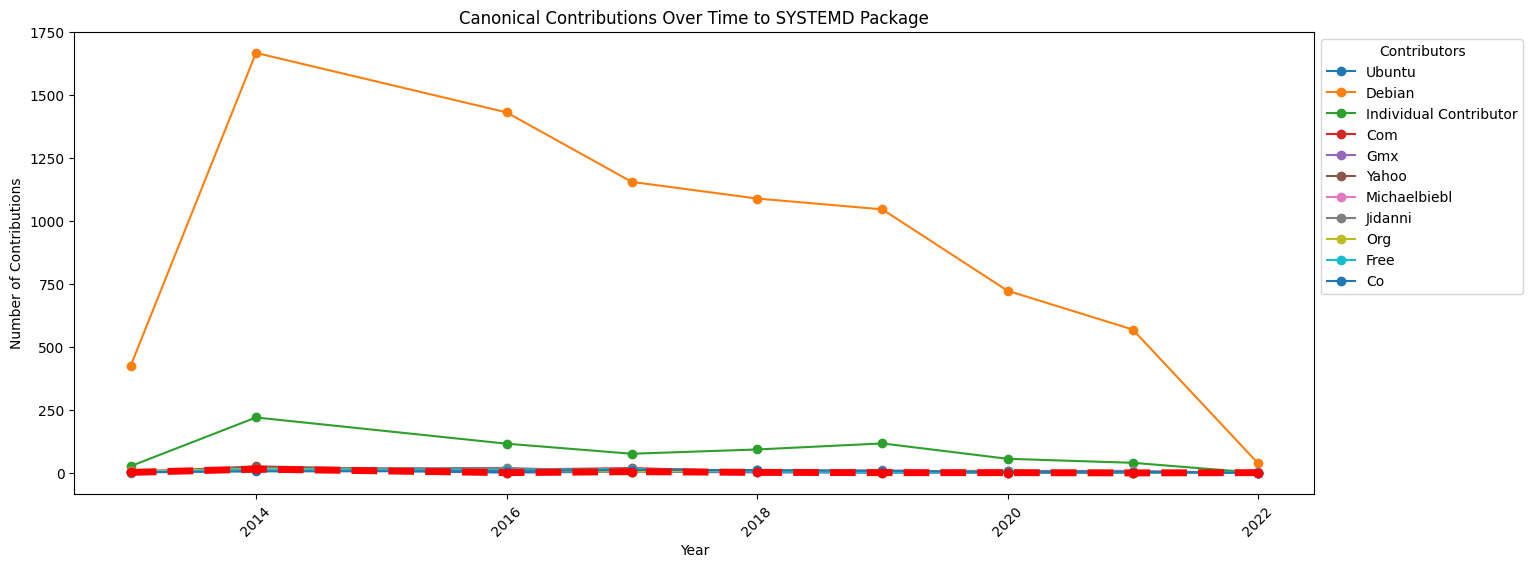

In [229]:
plot_chart(top_10_contributors_plus_ubuntu_transposed, "Canonical Contributions Over Time to SYSTEMD Package")

### APT

In [230]:
apt_df = pd.read_csv(folder_path + "email_content_apt_company_contributor.csv")

In [231]:
apt_df.head(50)

,Date,From,To,Subject,Content,Link,Company
0,2023-12-29 14:18:30+00:00,Patrice Duroux <patrice.duroux@gmail.com>,Debian Bug Tracking System <submit@bugs.debian...,Bug#1059629: apt: doing something like 'apt -t...,Package: apt\nVersion: 2.7.7\nSeverity: wishli...,https://lists.debian.org/deity/2023/deity-2023...,Gmail
1,2023-12-29 14:18:30+00:00,Patrice Duroux <patrice.duroux@gmail.com>,Debian Bug Tracking System <submit@bugs.debian...,Bug#1059629: apt: doing something like 'apt -t...,Package: apt\nVersion: 2.7.7\nSeverity: wishli...,https://lists.debian.org/deity/2023/deity-2023...,Gmail
2,2023-12-29 14:18:30+00:00,Patrice Duroux <patrice.duroux@gmail.com>,Debian Bug Tracking System <submit@bugs.debian...,Bug#1059629: apt: doing something like 'apt -t...,Package: apt\nVersion: 2.7.7\nSeverity: wishli...,https://lists.debian.org/deity/2023/deity-2023...,Gmail
3,2023-12-29 14:18:30+00:00,Patrice Duroux <patrice.duroux@gmail.com>,Debian Bug Tracking System <submit@bugs.debian...,Bug#1059629: apt: doing something like 'apt -t...,Package: apt\nVersion: 2.7.7\nSeverity: wishli...,https://lists.debian.org/deity/2023/deity-2023...,Gmail
4,2023-12-29 14:18:30+00:00,Patrice Duroux <patrice.duroux@gmail.com>,Debian Bug Tracking System <submit@bugs.debian...,Bug#1059629: apt: doing something like 'apt -t...,Package: apt\nVersion: 2.7.7\nSeverity: wishli...,https://lists.debian.org/deity/2023/deity-2023...,Gmail
5,2023-12-29 14:18:30+00:00,Patrice Duroux <patrice.duroux@gmail.com>,Debian Bug Tracking System <submit@bugs.debian...,Bug#1059629: apt: doing something like 'apt -t...,Package: apt\nVersion: 2.7.7\nSeverity: wishli...,https://lists.debian.org/deity/2023/deity-2023...,Gmail
6,2023-12-29 14:18:30+00:00,Patrice Duroux <patrice.duroux@gmail.com>,Debian Bug Tracking System <submit@bugs.debian...,Bug#1059629: apt: doing something like 'apt -t...,Package: apt\nVersion: 2.7.7\nSeverity: wishli...,https://lists.debian.org/deity/2023/deity-2023...,Gmail
7,2023-12-29 14:18:30+00:00,Patrice Duroux <patrice.duroux@gmail.com>,Debian Bug Tracking System <submit@bugs.debian...,Bug#1059629: apt: doing something like 'apt -t...,Package: apt\nVersion: 2.7.7\nSeverity: wishli...,https://lists.debian.org/deity/2023/deity-2023...,Gmail
8,2023-12-29 14:18:30+00:00,Patrice Duroux <patrice.duroux@gmail.com>,Debian Bug Tracking System <submit@bugs.debian...,Bug#1059629: apt: doing something like 'apt -t...,Package: apt\nVersion: 2.7.7\nSeverity: wishli...,https://lists.debian.org/deity/2023/deity-2023...,Gmail
9,2023-12-29 14:18:30+00:00,Patrice Duroux <patrice.duroux@gmail.com>,Debian Bug Tracking System <submit@bugs.debian...,Bug#1059629: apt: doing something like 'apt -t...,Package: apt\nVersion: 2.7.7\nSeverity: wishli...,https://lists.debian.org/deity/2023/deity-2023...,Gmail


#### **Email Thread Analysis**
Identify email threads based on the "Subject" field or by grouping emails with the same "From" and "To" addresses. Analyze the length of threads, the number of participants, response times, so on.

In [232]:
# Convert 'Date' column to datetime
apt_df['Date'] = pd.to_datetime(apt_df['Date'])

In [233]:
# Group emails by 'Subject' to identify threads
apt_email_threads = apt_df.groupby('Subject')

In [234]:
# Initialize lists to store analysis results
thread_subjects = []
thread_lengths = []
thread_participants = []
thread_start_dates = []
thread_end_dates = []

In [235]:
# Analyze each thread
for subject, thread_emails in apt_email_threads:
    # Get number of emails in the thread
    thread_length = len(thread_emails)

    # Get unique participants in the thread
    participants = thread_emails['From'].unique().tolist()

    # Get start and end dates of the thread
    start_date = thread_emails['Date'].min().strftime("%Y-%m-%d")
    end_date = thread_emails['Date'].max().strftime("%Y-%m-%d")

    # Append results to lists
    thread_subjects.append(subject)
    thread_lengths.append(thread_length)
    thread_participants.append(participants)
    thread_start_dates.append(start_date)
    thread_end_dates.append(end_date)

In [236]:
# Create DataFrame to store analysis results
apt_thread_analysis_df = pd.DataFrame({
    'Subject': thread_subjects,
    'Length': thread_lengths,
    'Participants': thread_participants,
    'Start Date': thread_start_dates,
    'End Date': thread_end_dates
})

In [237]:
# Display the thread analysis DataFrame
apt_thread_analysis_df = apt_thread_analysis_df.sort_values(by='Length', ascending=False, ignore_index=True)

In [238]:
apt_thread_analysis_df.head(5)

,Subject,Length,Participants,Start Date,End Date
0,Re: non-essential adduser poses problems to pu...,330,[Johannes Schauer Marin Rodrigues <josch@debia...,2023-05-07,2023-09-27
1,Re: Bug#969631: can base-passwd provide the us...,225,[Johannes Schauer Marin Rodrigues <josch@debia...,2021-08-25,2022-09-18
2,Processed: your mail,194,"[""Debian Bug Tracking System"" <owner@bugs.debi...",2014-11-01,2021-01-03
3,Bug#831762: apt data corrupts with MergeList,186,"[Ritesh Raj Sarraf <rrs@debian.org>, David Kal...",2016-07-19,2016-07-27
4,Bug#809029: apt: trusted=yes option in sources...,186,[Christoph Anton Mitterer <calestyo@scientia.n...,2015-12-26,2015-12-28


In [239]:
apt_thread_analysis_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5736 entries, 0 to 5735
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Subject       5736 non-null   object
 1   Length        5736 non-null   int64 
 2   Participants  5736 non-null   object
 3   Start Date    5736 non-null   object
 4   End Date      5736 non-null   object
dtypes: int64(1), object(4)
memory usage: 224.2+ KB


In [240]:
apt_thread_analysis_df['Participants']

0       [Johannes Schauer Marin Rodrigues <josch@debia...
1       [Johannes Schauer Marin Rodrigues <josch@debia...
2       ["Debian Bug Tracking System" <owner@bugs.debi...
3       [Ritesh Raj Sarraf <rrs@debian.org>, David Kal...
4       [Christoph Anton Mitterer <calestyo@scientia.n...
                              ...                        
5731                      [Axel Beckert <abe@debian.org>]
5732           [Marc Dequènes (duck) <duck@duckcorp.org>]
5733    [Frans Spiesschaert <Frans.Spiesschaert@yucom....
5734    [owner@bugs.debian.org(Debian Bug Tracking Sys...
5735    [Gordon Haverland <ghaverla@materialisations.c...
Name: Participants, Length: 5736, dtype: object

In [241]:
# Apply the function to extract company names from each email address in the 'Participants' column
apt_thread_analysis_df['Participants'] = apt_thread_analysis_df['Participants'].apply(lambda emails: [extract_company(email) for email in emails])

In [242]:
# Apply the function to each list element in the 'Participants' column
apt_thread_analysis_df['Participants'] = apt_thread_analysis_df['Participants'].apply(lambda companies: replace_companies(companies))

In [243]:
# Make the elements unique in each list
apt_thread_analysis_df['Participants'] = apt_thread_analysis_df['Participants'].apply(lambda emails: list(set(emails)))

In [244]:
apt_thread_analysis_df.head(10)

,Subject,Length,Participants,Start Date,End Date
0,Re: non-essential adduser poses problems to pu...,330,"[Debian, Zugschlus, Subdivi, Dandrimont]",2023-05-07,2023-09-27
1,Re: Bug#969631: can base-passwd provide the us...,225,"[Debian, Linux, Kalnischkies]",2021-08-25,2022-09-18
2,Processed: your mail,194,[Debian],2014-11-01,2021-01-03
3,Bug#831762: apt data corrupts with MergeList,186,"[Debian, Kalnischkies]",2016-07-19,2016-07-27
4,Bug#809029: apt: trusted=yes option in sources...,186,"[Thykier, Bebt, Scientia]",2015-12-26,2015-12-28
5,"Bug#832901: apt: ""apt upgrade -s"" tries to rem...",176,"[Debian, Vinc17, Kalnischkies]",2016-07-29,2016-07-30
6,Bug#931566: Don't complain about suite changes...,175,"[Debian, Kalnischkies]",2019-07-07,2021-04-19
7,Bug#961128: apt-transport-https: https fails w...,174,"[Pm, Debian, Mailbox, Protonmail, Kalnischkies]",2020-05-20,2020-05-25
8,Bug#869557: apt: please make the output of apt...,172,"[Debian, Tarsnap, Kalnischkies]",2017-07-24,2017-07-30
9,Re: Facilitating external repositories,166,"[Debian, Greenend, Uter, Kalnischkies]",2015-07-23,2015-08-17


In [245]:
# Filter the DataFrame to include only rows where 'Ubuntu' is in the list of participants
ubuntu_rows = apt_thread_analysis_df[apt_thread_analysis_df['Participants'].apply(lambda x: 'Ubuntu' in x)]

# Display the top 10 rows
top_10_ubuntu_rows = ubuntu_rows.head(10)

In [246]:
top_10_ubuntu_rows

,Subject,Length,Participants,Start Date,End Date
18,Re: [systemd-devel] Ordering (apt) timer servi...,140,"[Redhat, Individual Contributor, Debian, Ubunt...",2017-04-28,2017-04-29
51,Bug#812994: apt 1.2.1 fails to configure packages,102,"[Debian, Kubuntu, Jak-linux, Ubuntu]",2016-01-28,2016-02-10
56,Bug#800501: SystemError on missing files in /v...,96,"[Debian, Ubuntu]",2015-09-30,2015-09-30
103,Bug#810796: HTTP pipelining is broken and caus...,72,"[Debian, Ubuntu]",2016-01-12,2016-01-12
245,Re: Installing Acquire::IndexTargets requires ...,49,"[Debian, Ubuntu, Kalnischkies]",2016-03-07,2016-03-07
251,Bug#800500: Bug#800499: SystemError on unreada...,48,"[Debian, Ubuntu]",2015-09-30,2015-09-30
787,Bug#800499: SystemError on unreadable files in...,24,[Ubuntu],2015-09-30,2015-09-30
791,Bug#800500: SystemError on unreadable files in...,24,[Ubuntu],2015-09-30,2015-09-30
939,Bug#842228: Bug#640217: bash-completion: compl...,23,[Ubuntu],2016-10-27,2016-10-27
1273,Bug#812099: python-apt-common: unnecessary dep...,20,[Ubuntu],2016-01-20,2016-01-20


In [247]:
# Filter the DataFrame to include only rows where 'Ubuntu' is in the list of participants
ubuntu_rows = apt_thread_analysis_df[apt_thread_analysis_df['Participants'].apply(lambda x: 'Ubuntu' in x)]

In [248]:
# Find the start date and end date of Ubuntu's collaboration
start_date = ubuntu_rows['Start Date'].min()
end_date = ubuntu_rows['End Date'].max()

In [249]:
print(f"Canonical/Ubuntu's collaboration start date: {start_date}")
print(f"Canonical/Ubuntu's collaboration end date: {end_date}")

Canonical/Ubuntu's collaboration start date: 2014-09-09
Canonical/Ubuntu's collaboration end date: 2017-08-23


In [250]:
# Convert 'Start Date' to datetime format
ubuntu_rows.loc[:, 'Start Date'] = pd.to_datetime(ubuntu_rows['Start Date'])

# Get the Canonical contributions over time
ubuntu_contributions_over_time = ubuntu_rows.groupby(ubuntu_rows['Start Date'].dt.year).size()

<ipython-input-250-b4e7eeae5c08>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ubuntu_rows.loc[:, 'Start Date'] = pd.to_datetime(ubuntu_rows['Start Date'])
<ipython-input-250-b4e7eeae5c08>:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  ubuntu_rows.loc[:, 'Start Date'] = pd.to_datetime(ubuntu_rows['Start Date'])


In [251]:
# Convert Series to DataFrame with a single column
ubuntu_contributions_over_time_df = ubuntu_contributions_over_time.to_frame()

# Transpose the DataFrame
ubuntu_contributions_over_time_transposed = ubuntu_contributions_over_time_df.T

# Replace the index '0' with 'Ubuntu'
ubuntu_contributions_over_time_transposed = ubuntu_contributions_over_time_transposed.rename(index={0: 'Ubuntu'})

# Rename the column 'Start Date' to 'Year'
#ubuntu_contributions_over_time_transposed = ubuntu_contributions_over_time_transposed.rename_axis(columns='Year')
ubuntu_contributions_over_time_transposed = ubuntu_contributions_over_time_transposed

# Print the transposed DataFrame
ubuntu_contributions_over_time_transposed

Start Date,2014,2015,2016,2017
Ubuntu,1,5,9,3


In [252]:
# Convert start_date and end_date to datetime objects
start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

# Filter the DataFrame to include only non-Ubuntu rows within the start and end dates of Ubuntu's collaboration
non_ubuntu_rows_filtered = apt_thread_analysis_df[
    (apt_thread_analysis_df['Participants'].apply(lambda x: 'Ubuntu' not in x)) &
    (pd.to_datetime(apt_thread_analysis_df['Start Date']) >= start_date) &
    (pd.to_datetime(apt_thread_analysis_df['End Date']) <= end_date)
]

# Explode the 'Participants' column
non_ubuntu_rows_exploded = non_ubuntu_rows_filtered.explode('Participants')

# Convert 'Start Date' to datetime format
non_ubuntu_rows_exploded['Start Date'] = pd.to_datetime(non_ubuntu_rows_exploded['Start Date'])

# Group by participant and year to get contributions over time for each non-Ubuntu participant
non_ubuntu_contributions_over_time = non_ubuntu_rows_exploded.groupby(['Participants', non_ubuntu_rows_exploded['Start Date'].dt.year]).size().unstack(fill_value=0)

# Transpose the DataFrame to have participants as rows and years as columns
# non_ubuntu_contributions_over_time_transposed = non_ubuntu_contributions_over_time.transpose()

# Display the transposed DataFrame
# non_ubuntu_contributions_over_time_transposed
non_ubuntu_contributions_over_time

Start Date,2014,2015,2016,2017
Participants,,,,
126,0,0,1,0
5challer,0,4,0,0
A-little-linux-box,0,0,3,0
Ac,1,0,0,1
Acorntoolworks,0,0,1,0
...,...,...,...,...
Yandex,0,7,2,1
Yucom,1,1,6,2
Znn,0,1,0,0


In [253]:
# Sum the contributions across all years for each participant
non_ubuntu_contributions_over_time['Total Contributions'] = non_ubuntu_contributions_over_time.sum(axis=1)

# Sort the participants based on the total contributions in descending order
top_10_non_ubuntu_participants = non_ubuntu_contributions_over_time.sort_values(by='Total Contributions', ascending=False).head(10)

# Drop the Total Contributions column
top_10_non_ubuntu_participants = top_10_non_ubuntu_participants.drop(columns=['Total Contributions'])

# Display the top 10 participants
top_10_non_ubuntu_participants

Start Date,2014,2015,2016,2017
Participants,,,,
Debian,233,936,726,322
Individual Contributor,30,105,98,32
Kalnischkies,30,84,98,32
Thykier,3,19,10,3
Yahoo,1,7,5,6
Co,3,7,5,2
Gmx,3,4,6,3
Mirbsd,2,6,4,3
Vinc17,1,3,9,2


In [254]:
# Concatenate the two DataFrames with 'ubuntu_contributions_over_time_transposed' as the first row
top_10_contributors_plus_ubuntu = pd.concat([ubuntu_contributions_over_time_transposed] + [top_10_non_ubuntu_participants])

# Rename the 'Start Date' column to 'Year' in top_10_non_ubuntu_participants DataFrame
top_10_contributors_plus_ubuntu = top_10_contributors_plus_ubuntu.rename_axis(columns='Year')

# Fill NaN values with 0 and convert all values to integers
top_10_contributors_plus_ubuntu = top_10_contributors_plus_ubuntu.fillna(0).astype(int)

# Sort the columns in ascending order
top_10_contributors_plus_ubuntu = top_10_contributors_plus_ubuntu.reindex(sorted(top_10_contributors_plus_ubuntu.columns), axis=1)

# Print the final DataFrame
top_10_contributors_plus_ubuntu

Year,2014,2015,2016,2017
Ubuntu,1,5,9,3
Debian,233,936,726,322
Individual Contributor,30,105,98,32
Kalnischkies,30,84,98,32
Thykier,3,19,10,3
Yahoo,1,7,5,6
Co,3,7,5,2
Gmx,3,4,6,3
Mirbsd,2,6,4,3
Vinc17,1,3,9,2


In [255]:
top_10_contributors_plus_ubuntu_transposed = top_10_contributors_plus_ubuntu.transpose()

Plot saved as '/content/drive/My Drive/IMT Atlantique/Semester 2/Project Complex/Coding/data/final/img_discussion_space_analysis/Canonical Contributions Over Time to APT Package.png'


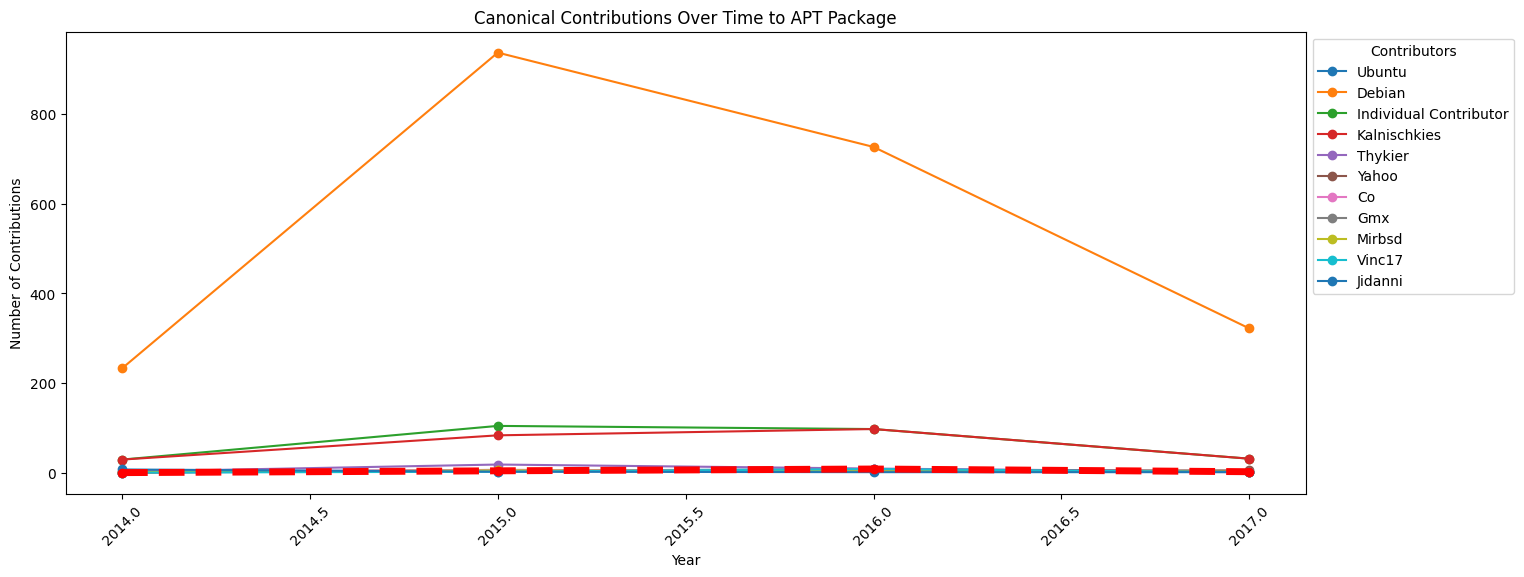

In [256]:
plot_chart(top_10_contributors_plus_ubuntu_transposed, "Canonical Contributions Over Time to APT Package")